In [3]:
import sys
import os
import platform
import importlib
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt
if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
elif platform.system() == 'Linux':
    base_FP = '/data'
    cpuserver_data_FP = '/data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')
print(base_FP, cpuserver_data_FP)

#hydroAI libs
import HydroAI.ASCAT_TUW as hASCAT_TUW
import HydroAI.Plot as hPlot
import HydroAI.Data as hData
import HydroAI.Grid as hGrid
importlib.reload(hASCAT_TUW)
importlib.reload(hPlot)
importlib.reload(hData)
importlib.reload(hGrid)

# Ignore runtime warnings
import warnings
warnings.filterwarnings("ignore")

# Define your directory where to save nc files
nc_save_dir      = cpuserver_data_FP + '/extracted_nc'
output_dir       = cpuserver_data_FP + '/ASCAT/TUW/csv'
output_dir_nc_3d = cpuserver_data_FP + '/ASCAT/TUW/nc_3d'

/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive /Users/hyunglokkim/cpuserver_data


## 0. Basic settings

In [4]:
# get the WARP5 Grid Information (GI) nc file
ASCAT_FP = cpuserver_data_FP + '/ASCAT/TUW'
GI_file_path = os.path.join(ASCAT_FP, 'warp5_grid/TUW_WARP5_grid_info_2_3.nc')
# check the variable names and their units
hData.get_nc_variable_names_units(GI_file_path);

gpi = hData.get_variable_from_nc(GI_file_path, 'gpi')
lat = hData.get_variable_from_nc(GI_file_path, 'lat')
lon = hData.get_variable_from_nc(GI_file_path, 'lon')
cell = hData.get_variable_from_nc(GI_file_path, 'cell')

+----------------+------------------------------+---------------+
| Name           | Long Name                    | Units         |
+================+==============================+===============+
| lon            | location longitude           | degrees_east  |
+----------------+------------------------------+---------------+
| lat            | location latitude            | degrees_north |
+----------------+------------------------------+---------------+
| gpi            | grid point index             |               |
+----------------+------------------------------+---------------+
| cell           | cell number                  |               |
+----------------+------------------------------+---------------+
| land_flag      | land flag                    |               |
+----------------+------------------------------+---------------+
| committed_area | Committed soil moisture area |               |
+----------------+------------------------------+---------------+


In [17]:
# get reprojection and date information
target_resol = 0.25
resampled_name = 'R_Noah_025'
target_lon, target_lat = hGrid.generate_lon_lat_eqdgrid(target_resol)
am_pm = ['pm', 'am']
start_year = 2022
end_year   = 2022
num_days   = (datetime(end_year+1,1,1) - datetime(start_year,1,1)).days
cutoff_datetime = pd.to_datetime(str(end_year+1)+'-01-01 00:00:00')

In [6]:
# get the porosity data
porosity_file_path = os.path.join(ASCAT_FP, 'static_layer/porosity.nc')
por_gldas = hData.get_variable_from_nc(porosity_file_path, 'por_gldas')
por_hwsd = hData.get_variable_from_nc(porosity_file_path, 'por_hwsd')

## 1. Import ASCAT data from raw files

In [7]:
# ASCAT nc files
nc_file_path = os.path.join(ASCAT_FP, 'h119')
h119 = hData.get_file_list(nc_file_path, 'nc')
nc_file_path = os.path.join(ASCAT_FP, 'h120')
h120 = hData.get_file_list(nc_file_path, 'nc')
ASCAT_file_path = h119+h120
hData.get_nc_variable_names_units(ASCAT_file_path[0]);
nof = len(ASCAT_file_path)

+----------------------+-----------------------------------------+--------------------------------+
| Name                 | Long Name                               | Units                          |
+======================+=========================================+================================+
| row_size             | number of observations at this location |                                |
+----------------------+-----------------------------------------+--------------------------------+
| lon                  | location longitude                      | degrees_east                   |
+----------------------+-----------------------------------------+--------------------------------+
| lat                  | location latitude                       | degrees_north                  |
+----------------------+-----------------------------------------+--------------------------------+
| alt                  | vertical distance above the surface     | m                              |


In [8]:
unique_cell_numbers = []
index_map = {}
for index, path in enumerate(ASCAT_file_path):
    identifier = path.split('_')[-1].split('.')[0]
    if identifier not in unique_cell_numbers:
        unique_cell_numbers.append(identifier)
        index_map[identifier] = [index]
    else:
        index_map[identifier].append(index)

## 1-1. Creat core csv files (should be updated yearly basis -- last updated Jun 1 2024)

In [10]:
# [Example] Single file operator
geo_vars = ['row_size', 'lon', 'lat', 'location_id']
obs_vars = ['time', 'sm', 'sm_noise', 'ssf', 'dir', 'proc_flag', 'corr_flag', 'conf_flag','sigma40', 'sigma40_noise']

# Extract geolocation related data for a specific k
for k in [2]:#range(unique_cell_numbers):

    h_file_index = index_map.get(unique_cell_numbers[k], [])
    
    obs_df_list = []
    for kk in h_file_index:
        t_ASCAT_file_name = ASCAT_file_path[kk]
        t_cell_number = t_ASCAT_file_name[-7:-3] # cell #
        #t_h_number = t_ASCAT_file_name[-11:-8]   # H119 or H120
    
        print(t_ASCAT_file_name)
        # Extract geolocation related data
        geo_df = pd.DataFrame(columns=geo_vars).drop(columns='row_size')
        t_row_size = hData.get_variable_from_nc(t_ASCAT_file_name, 'row_size')
        t_lon = hData.get_variable_from_nc(t_ASCAT_file_name, 'lon')
        t_lat = hData.get_variable_from_nc(t_ASCAT_file_name, 'lat')
        t_location_id = hData.get_variable_from_nc(t_ASCAT_file_name, 'location_id')
        
        # Extract observation related data
        t_time = hData.get_variable_from_nc(t_ASCAT_file_name, 'time')
        t_sm = hData.get_variable_from_nc(t_ASCAT_file_name, 'sm')
        t_sm_noise = hData.get_variable_from_nc(t_ASCAT_file_name, 'sm_noise')
        t_ssf = hData.get_variable_from_nc(t_ASCAT_file_name, 'ssf')
        t_dir = hData.get_variable_from_nc(t_ASCAT_file_name, 'dir')
        t_proc_flag = hData.get_variable_from_nc(t_ASCAT_file_name, 'proc_flag')
        t_corr_flag = hData.get_variable_from_nc(t_ASCAT_file_name, 'corr_flag')
        t_conf_flag = hData.get_variable_from_nc(t_ASCAT_file_name, 'conf_flag')
        t_sigma40 = hData.get_variable_from_nc(t_ASCAT_file_name, 'sigma40')
        t_sigma40_noise = hData.get_variable_from_nc(t_ASCAT_file_name, 'sigma40_noise')
        
        t_dir = t_dir.astype(float)  # Convert orbit_dir to float
        t_row_size = t_row_size[~np.isnan(t_row_size)]
        obs_partial_df = pd.DataFrame(index=np.arange(t_row_size.sum()), columns=obs_vars+['lon', 'lat', 'location_id'])
        
        # Save them to dataframes
        row_start = np.zeros(len(t_row_size), dtype=int)
        row_end = np.zeros(len(t_row_size), dtype=int)
    
        for i in range(len(t_row_size)):
    
            geo_df.loc[i, 'lon'] = t_lon[i]
            geo_df.loc[i, 'lat'] = t_lat[i]
            geo_df.loc[i, 'location_id'] = t_location_id[i]
                
            if i == 0:
                row_start[0] = 0
                row_end[0] = t_row_size[0]
            else:
                row_start[i] = row_end[i-1]
                row_end[i] = row_start[i] + t_row_size[i]
        
            for var in obs_vars:
                obs_partial_df.loc[row_start[i]:row_end[i]-1, var] = globals()[f't_{var}'][row_start[i]:row_end[i]]
    
            obs_partial_df.loc[row_start[i]:row_end[i]-1, 'lon'] = geo_df.loc[i, 'lon']
            obs_partial_df.loc[row_start[i]:row_end[i]-1, 'lat'] = geo_df.loc[i, 'lat']
            obs_partial_df.loc[row_start[i]:row_end[i]-1, 'location_id'] = geo_df.loc[i, 'location_id']
             
        # Append the partial DataFrame to the list
        obs_df_list.append(obs_partial_df)
    
    # Concatenate all partial DataFrames into a single DataFrame
    obs_df = pd.concat(obs_df_list, ignore_index=True)
    obs_df['local_time'] = hASCAT_TUW.convert_to_local_time(obs_df)
    obs_df.to_csv(os.path.join(output_dir, 'h119_h120_'+t_cell_number+'.csv'))

/Users/hyunglokkim/cpuserver_data/ASCAT/TUW/h119/H119_0032.nc
/Users/hyunglokkim/cpuserver_data/ASCAT/TUW/h120/H120_0032.nc


In [ ]:
# [Operational] Parallelize the execution of the loop using joblib
# Function to process data for a specific range of k values
def process_data(k_range, unique_cell_numbers):
    for k in k_range:
        h_file_index = index_map.get(unique_cell_numbers[k], [])

        obs_df_list = []
        for kk in h_file_index:
            t_ASCAT_file_name = ASCAT_file_path[kk]
            t_cell_number = t_ASCAT_file_name[-7:-3]  # cell #
            #t_h_number = t_ASCAT_file_name[-11:-8]   # H119 or H120

            print(t_ASCAT_file_name)
            # Extract geolocation related data
            geo_df = pd.DataFrame(columns=geo_vars).drop(columns='row_size')
            
            t_row_size = hData.get_variable_from_nc(t_ASCAT_file_name, 'row_size')
            t_lon = hData.get_variable_from_nc(t_ASCAT_file_name, 'lon')
            t_lat = hData.get_variable_from_nc(t_ASCAT_file_name, 'lat')
            t_location_id = hData.get_variable_from_nc(t_ASCAT_file_name, 'location_id')
            
            # Extract observation related data
            for var in obs_vars:
                globals()[f't_{var}'] = hData.get_variable_from_nc(t_ASCAT_file_name, var)
                
            t_time = hData.get_variable_from_nc(t_ASCAT_file_name, 'time')
            t_sm = hData.get_variable_from_nc(t_ASCAT_file_name, 'sm')
            t_sm_noise = hData.get_variable_from_nc(t_ASCAT_file_name, 'sm_noise')
            t_ssf = hData.get_variable_from_nc(t_ASCAT_file_name, 'ssf')
            t_dir = hData.get_variable_from_nc(t_ASCAT_file_name, 'dir')
            t_proc_flag = hData.get_variable_from_nc(t_ASCAT_file_name, 'proc_flag')
            t_corr_flag = hData.get_variable_from_nc(t_ASCAT_file_name, 'corr_flag')
            t_conf_flag = hData.get_variable_from_nc(t_ASCAT_file_name, 'conf_flag')
            t_sigma40 = hData.get_variable_from_nc(t_ASCAT_file_name, 'sigma40')
            t_sigma40_noise = hData.get_variable_from_nc(t_ASCAT_file_name, 'sigma40_noise')
            
            t_dir = t_dir.astype(float)  # Convert orbit_dir to float
            t_row_size = t_row_size[~np.isnan(t_row_size)]
            obs_partial_df = pd.DataFrame(index=np.arange(t_row_size.sum()), columns=obs_vars+['lon', 'lat', 'location_id'])

            # Save them to dataframes
            row_start = np.zeros(len(t_row_size), dtype=int)
            row_end = np.zeros(len(t_row_size), dtype=int)

            for i in range(len(t_row_size)):
                geo_df.loc[i, 'lon'] = t_lon[i]
                geo_df.loc[i, 'lat'] = t_lat[i]
                geo_df.loc[i, 'location_id'] = t_location_id[i]

                if i == 0:
                    row_start[0] = 0
                    row_end[0] = t_row_size[0]
                else:
                    row_start[i] = row_end[i-1]
                    row_end[i] = row_start[i] + t_row_size[i]

                for var in obs_vars:
                    obs_partial_df.loc[row_start[i]:row_end[i]-1, var] = globals()[f't_{var}'][row_start[i]:row_end[i]]

                obs_partial_df.loc[row_start[i]:row_end[i]-1, 'lon'] = geo_df.loc[i, 'lon']
                obs_partial_df.loc[row_start[i]:row_end[i]-1, 'lat'] = geo_df.loc[i, 'lat']
                obs_partial_df.loc[row_start[i]:row_end[i]-1, 'location_id'] = geo_df.loc[i, 'location_id']

            # Append the partial DataFrame to the list
            obs_df_list.append(obs_partial_df)

        # Concatenate all partial DataFrames into a single DataFrame
        obs_df = pd.concat(obs_df_list, ignore_index=True)
        obs_df['local_time'] = hData.convert_to_local_time(obs_df)
        #obs_df.to_csv(os.path.join(output_dir, 't_h119_h120_' + t_cell_number + '.csv'))
        obs_df.to_csv(os.path.join(output_dir, 'h119_h120_' + t_cell_number + '.csv'))

# Number of processors to use
n_processors = 48

# Divide the range into chunks based on the number of processors
chunk_size = len(unique_cell_numbers) // n_processors
ranges = [range(i * chunk_size, (i + 1) * chunk_size) for i in range(n_processors)]

# If there are remaining elements, add them to the last chunk
if len(unique_cell_numbers) % n_processors != 0:
    ranges[-1] = range((n_processors - 1) * chunk_size, len(unique_cell_numbers))

# Run the processing in parallel
Parallel(n_jobs=n_processors)(delayed(process_data)(k_range, unique_cell_numbers) for k_range in ranges)

## 1-2. Creat core nc files based on the core csv files above

In [ ]:
csv_folder = os.path.join(ASCAT_FP, 'csv')
csv_file_path = hData.get_file_list(csv_folder, 'csv')

In [74]:
i = 89 #740 # for Korea
orbit = 0 # 0: ascending (pm; 21:30) / 1: descending (am; 9:30)

t_csv_file_name = csv_file_path[i]
print(t_csv_file_name)
t_cell_number   = t_csv_file_name[-8:-4]
t_lat           = pd.read_csv(t_csv_file_name, usecols=['lat'])
t_lon           = pd.read_csv(t_csv_file_name, usecols=['lon'])
t_local_time    = pd.read_csv(t_csv_file_name, usecols=['local_time'])
t_time          = pd.read_csv(t_csv_file_name, usecols=['time'])
t_location_id   = pd.read_csv(t_csv_file_name, usecols=['location_id'])
t_sm            = pd.read_csv(t_csv_file_name, usecols=['sm'])
t_conf_flag     = pd.read_csv(t_csv_file_name, usecols=['conf_flag'])
t_dir           = pd.read_csv(t_csv_file_name, usecols=['dir'])

/Users/hyunglokkim/cpuserver_data/ASCAT/TUW/csv/h119_h120_0567.csv


In [75]:
# Convert fractional days to datetime
base_date = datetime(1900, 1, 1)
t_local_time['datetime'] = t_local_time['local_time'].apply(lambda x: base_date + timedelta(days=x))

# Define the base year for DOY calculation
base_year = start_year
# Calculate DOY
t_local_time['doy'] = t_local_time['datetime'].apply(lambda x: hASCAT_TUW.calculate_doy(x, base_year))

In [76]:
# Find closest index of the current cell data
t_ll_idx = hData.find_closest_index(target_lon, target_lat, [np.min(t_lon), np.min(t_lat)])
t_lr_idx = hData.find_closest_index(target_lon, target_lat, [np.max(t_lon), np.min(t_lat)])
t_ul_idx = hData.find_closest_index(target_lon, target_lat, [np.min(t_lon), np.max(t_lat)])
t_ur_idx = hData.find_closest_index(target_lon, target_lat, [np.max(t_lon), np.max(t_lat)])

# Create target data frames for raw and QC data
t_target_frame_gldas       = hData.create_3d_object_array(t_ll_idx[0]-t_ul_idx[0]+1, t_lr_idx[1]-t_ll_idx[1]+1, num_days+1) #+1 because python starts from 0
t_target_frame_hwsd        = hData.create_3d_object_array(t_ll_idx[0]-t_ul_idx[0]+1, t_lr_idx[1]-t_ll_idx[1]+1, num_days+1) 
t_final_target_frame_gldas = hData.create_3d_np_array(t_ll_idx[0]-t_ul_idx[0]+1, t_lr_idx[1]-t_ll_idx[1]+1, num_days+1)
t_final_target_frame_hwsd  = hData.create_3d_np_array(t_ll_idx[0]-t_ul_idx[0]+1, t_lr_idx[1]-t_ll_idx[1]+1, num_days+1)

t_target_frame_gldas_QC       = hData.create_3d_object_array(t_ll_idx[0]-t_ul_idx[0]+1, t_lr_idx[1]-t_ll_idx[1]+1, num_days+1)
t_target_frame_hwsd_QC        = hData.create_3d_object_array(t_ll_idx[0]-t_ul_idx[0]+1, t_lr_idx[1]-t_ll_idx[1]+1, num_days+1) 
t_final_target_frame_gldas_QC = hData.create_3d_np_array(t_ll_idx[0]-t_ul_idx[0]+1, t_lr_idx[1]-t_ll_idx[1]+1, num_days+1)
t_final_target_frame_hwsd_QC  = hData.create_3d_np_array(t_ll_idx[0]-t_ul_idx[0]+1, t_lr_idx[1]-t_ll_idx[1]+1, num_days+1)

t_target_lon   = target_lon[t_ul_idx[0]:t_ll_idx[0]+1, t_ll_idx[1]:t_lr_idx[1]+1]
t_target_lat   = target_lat[t_ul_idx[0]:t_ll_idx[0]+1, t_ll_idx[1]:t_lr_idx[1]+1]

# Create porosity data frames for gldas and hwsd(just check for the difference)
t_por_gldas = hData.create_3d_np_array(t_ll_idx[0]-t_ul_idx[0]+1, t_lr_idx[1]-t_ll_idx[1]+1, 0)
t_por_hwsd  = hData.create_3d_np_array(t_ll_idx[0]-t_ul_idx[0]+1, t_lr_idx[1]-t_ll_idx[1]+1, 0)

In [77]:
t_unique_location_id = pd.DataFrame(np.unique(t_location_id['location_id']).astype('int'), columns=['unique_location_id'])
for ti in range(len(t_unique_location_id)):
    t_lat_idx = hData.find_closest_index(t_target_lon, t_target_lat, [lon[t_unique_location_id.unique_location_id[ti]], lat[t_unique_location_id.unique_location_id[ti]]])[0]
    t_lon_idx = hData.find_closest_index(t_target_lon, t_target_lat, [lon[t_unique_location_id.unique_location_id[ti]], lat[t_unique_location_id.unique_location_id[ti]]])[1]
    t_unique_location_id.loc[ti, 'lat_idx'] = int(t_lat_idx)
    t_unique_location_id.loc[ti, 'lon_idx'] = int(t_lon_idx)

In [78]:
# Create gldas and hwsd porosity map for comparison
t_por_gldas[t_unique_location_id['lat_idx'].astype('int'), t_unique_location_id['lon_idx'].astype('int')] = por_gldas[t_unique_location_id['unique_location_id']]
t_por_hwsd[t_unique_location_id['lat_idx'].astype('int'), t_unique_location_id['lon_idx'].astype('int')]  = por_hwsd[t_unique_location_id['unique_location_id']]

In [79]:
# QC vs non-QC process (with gldas and hwsd porosity)
t_data_filter    = (t_local_time['datetime'] < cutoff_datetime) & (t_dir['dir'] == orbit) & (t_local_time['doy']>0)
t_data_filter_QC = t_data_filter & (t_conf_flag['conf_flag'] == 0) 

tt_sm           = t_sm.loc[t_data_filter].reset_index(drop=True)
tt_local_time   = t_local_time[t_data_filter].reset_index(drop=True)
tt_location_id  = t_location_id[t_data_filter].reset_index(drop=True)
tt_conf_flag    = t_conf_flag[t_data_filter].reset_index(drop=True)

tt_sm_QC          = t_sm.loc[t_data_filter_QC].reset_index(drop=True)
tt_local_time_QC  = t_local_time[t_data_filter_QC].reset_index(drop=True)
tt_location_id_QC = t_location_id[t_data_filter_QC].reset_index(drop=True)
tt_conf_flag_QC   = t_conf_flag[t_data_filter_QC].reset_index(drop=True)

for si in tqdm(range(len(tt_sm))):
    tt_lat_idx   = t_unique_location_id[t_unique_location_id['unique_location_id'] == tt_location_id.iloc[si][0]].lat_idx.iloc[0].astype('int')
    tt_lon_idx   = t_unique_location_id[t_unique_location_id['unique_location_id'] == tt_location_id.iloc[si][0]].lon_idx.iloc[0].astype('int')
    tt_por_gldas = por_gldas[tt_location_id.iloc[si][0].astype('int')]
    tt_por_hwsd  = por_hwsd[tt_location_id.iloc[si][0].astype('int')]
    tt_doy       = tt_local_time.iloc[si]['doy']
    
    t_target_frame_gldas[tt_lat_idx, tt_lon_idx, tt_doy].append(tt_sm.iloc[si]['sm']*tt_por_gldas)
    t_target_frame_hwsd[tt_lat_idx, tt_lon_idx, tt_doy].append(tt_sm.iloc[si]['sm']*tt_por_hwsd)

for si in tqdm(range(len(tt_sm_QC))):
    tt_lat_idx   = t_unique_location_id[t_unique_location_id['unique_location_id'] == tt_location_id_QC.iloc[si][0]].lat_idx.iloc[0].astype('int')
    tt_lon_idx   = t_unique_location_id[t_unique_location_id['unique_location_id'] == tt_location_id_QC.iloc[si][0]].lon_idx.iloc[0].astype('int')
    tt_por_gldas = por_gldas[tt_location_id_QC.iloc[si][0].astype('int')]
    tt_por_hwsd  = por_hwsd[tt_location_id_QC.iloc[si][0].astype('int')]
    tt_doy       = tt_local_time_QC.iloc[si]['doy']
    
    t_target_frame_gldas_QC[tt_lat_idx, tt_lon_idx, tt_doy].append(tt_sm_QC.iloc[si]['sm']*tt_por_gldas)
    t_target_frame_hwsd_QC[tt_lat_idx, tt_lon_idx, tt_doy].append(tt_sm_QC.iloc[si]['sm']*tt_por_hwsd)

t_final_target_frame_gldas    = hData.object_array_to_np(t_target_frame_gldas, t_final_target_frame_gldas)
t_final_target_frame_hwsd     = hData.object_array_to_np(t_target_frame_hwsd, t_final_target_frame_hwsd)
t_final_target_frame_gldas_QC = hData.object_array_to_np(t_target_frame_gldas_QC, t_final_target_frame_gldas_QC)
t_final_target_frame_hwsd_QC  = hData.object_array_to_np(t_target_frame_hwsd_QC, t_final_target_frame_hwsd_QC)

# save data
t_nc_file_name = 'ASCAT_TUW_'+str(start_year)+'_'+str(end_year)+'_'+am_pm[orbit]+'_'+resampled_name+'_cell_'+t_cell_number+'.nc'
'''
t_nc_file_name = os.path.join(output_dir_nc_3d, t_nc_file_name)
hData.create_netcdf_file(
        nc_file    = t_nc_file_name,
        latitude   = t_target_lat,
        longitude  = t_target_lon,
        Resampled_ASCAT_SM_gldas    = t_final_target_frame_gldas,
        Resampled_ASCAT_SM_gldas_QC = t_final_target_frame_gldas_QC,
        Resampled_ASCAT_SM_hwsd     = t_final_target_frame_hwsd,
        Resampled_ASCAT_SM_hwsd_QC  = t_final_target_frame_hwsd_QC,
)
'''

100%|█████████████████████████████████| 272379/272379 [01:21<00:00, 3339.28it/s]


'\nt_nc_file_name = os.path.join(output_dir_nc_3d, t_nc_file_name)\nhData.create_netcdf_file(\n        nc_file    = t_nc_file_name,\n        latitude   = t_target_lat,\n        longitude  = t_target_lon,\n        Resampled_ASCAT_SM_gldas    = t_final_target_frame_gldas,\n        Resampled_ASCAT_SM_gldas_QC = t_final_target_frame_gldas_QC,\n        Resampled_ASCAT_SM_hwsd     = t_final_target_frame_hwsd,\n        Resampled_ASCAT_SM_hwsd_QC  = t_final_target_frame_hwsd_QC,\n)\n'

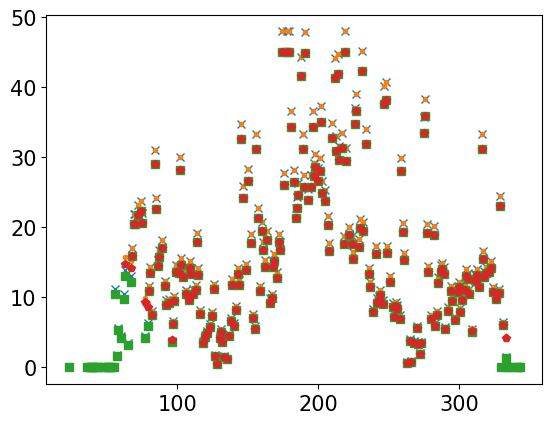

In [45]:
plt.plot(t_final_target_frame_gldas[1,6,:],'x')
plt.plot(t_final_target_frame_gldas_QC[1,6,:], '.')
plt.plot(t_final_target_frame_hwsd[1,6,:], 's')
plt.plot(t_final_target_frame_hwsd_QC[1,6,:], 'p')

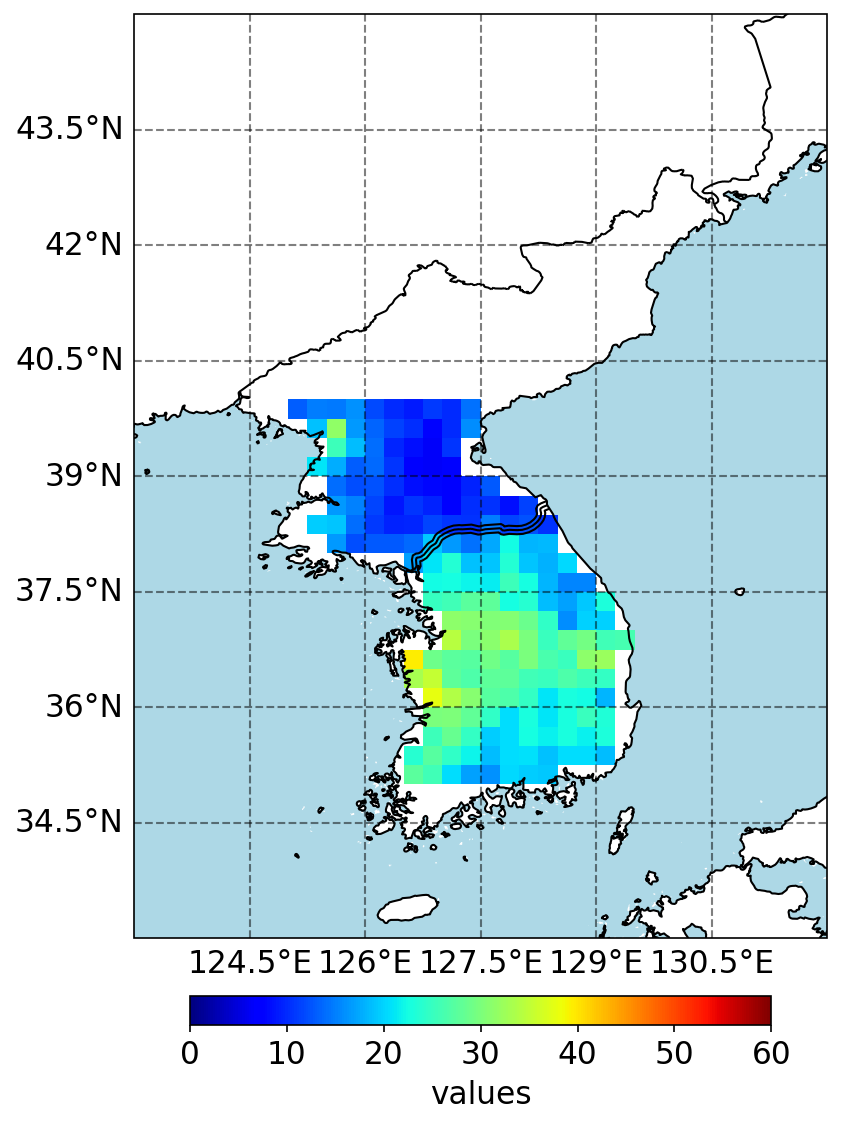

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [68]:
ttt = np.nanmean(t_final_target_frame_gldas, axis=2)
ttt = t_final_target_frame_gldas[:,:,108]
#bounds = [-180, 180, -90, 90]
bounds = [123, 132, 33, 45]
hPlot.plot_map(t_target_lon, t_target_lat, ttt, 0, 60, bounds=bounds,projection='PlateCarree')
#ttt = np.nanmean(t_final_target_frame_hwsd, axis=2)
#hPlot.plot_map(t_target_lon, t_target_lat, ttt, 0, 60, projection='PlateCarree')
#hPlot.plot_map(t_target_lon, t_target_lat, t_por_gldas, 0.3, 1, projection='PlateCarree')
#hPlot.plot_map(t_target_lon, t_target_lat, t_por_hwsd, 0.3, 1, projection='PlateCarree')

In [ ]:
# [Operational]
def process_file_nc(i, csv_file_path, target_lon, target_lat, start_year, end_year, cutoff_datetime, resampled_name, output_dir):
    t_csv_file_name = csv_file_path[i]
    print(t_csv_file_name)
    t_cell_number   = t_csv_file_name[-8:-4]
    t_lat           = pd.read_csv(t_csv_file_name, usecols=['lat'])
    t_lon           = pd.read_csv(t_csv_file_name, usecols=['lon'])
    t_local_time    = pd.read_csv(t_csv_file_name, usecols=['local_time'])
    t_time          = pd.read_csv(t_csv_file_name, usecols=['time'])
    t_location_id   = pd.read_csv(t_csv_file_name, usecols=['location_id'])
    t_sm            = pd.read_csv(t_csv_file_name, usecols=['sm'])
    t_conf_flag     = pd.read_csv(t_csv_file_name, usecols=['conf_flag'])
    t_dir           = pd.read_csv(t_csv_file_name, usecols=['dir'])
    
    # Convert fractional days to datetime
    base_date = datetime(1900, 1, 1)
    t_local_time['datetime'] = t_local_time['local_time'].apply(lambda x: base_date + timedelta(days=x))
    
    # Define the base year for DOY calculation
    base_year = start_year
    # Calculate DOY
    t_local_time['doy'] = t_local_time['datetime'].apply(lambda x: hASCAT_TUW.calculate_doy(x, base_year))
    
    # Find closest index of the current cell data
    t_ll_idx = hData.find_closest_index(target_lon, target_lat, [np.min(t_lon), np.min(t_lat)])
    t_lr_idx = hData.find_closest_index(target_lon, target_lat, [np.max(t_lon), np.min(t_lat)])
    t_ul_idx = hData.find_closest_index(target_lon, target_lat, [np.min(t_lon), np.max(t_lat)])
    t_ur_idx = hData.find_closest_index(target_lon, target_lat, [np.max(t_lon), np.max(t_lat)])
    
    t_target_lon   = target_lon[t_ul_idx[0]:t_ll_idx[0]+1, t_ll_idx[1]:t_lr_idx[1]+1]
    t_target_lat   = target_lat[t_ul_idx[0]:t_ll_idx[0]+1, t_ll_idx[1]:t_lr_idx[1]+1]
    
    # Create porosity data frames for gldas and hwsd(just check for the difference)
    t_por_gldas = hData.create_3d_np_array(t_ll_idx[0]-t_ul_idx[0]+1, t_lr_idx[1]-t_ll_idx[1]+1, 0)
    t_por_hwsd  = hData.create_3d_np_array(t_ll_idx[0]-t_ul_idx[0]+1, t_lr_idx[1]-t_ll_idx[1]+1, 0)
    
    t_unique_location_id = pd.DataFrame(np.unique(t_location_id['location_id']).astype('int'), columns=['unique_location_id'])
    for ti in range(len(t_unique_location_id)):
        t_lat_idx = hData.find_closest_index(t_target_lon, t_target_lat, [lon[t_unique_location_id.unique_location_id[ti]], lat[t_unique_location_id.unique_location_id[ti]]])[0]
        t_lon_idx = hData.find_closest_index(t_target_lon, t_target_lat, [lon[t_unique_location_id.unique_location_id[ti]], lat[t_unique_location_id.unique_location_id[ti]]])[1]
        t_unique_location_id.loc[ti, 'lat_idx'] = int(t_lat_idx)
        t_unique_location_id.loc[ti, 'lon_idx'] = int(t_lon_idx)
        
    t_unique_location_id = pd.DataFrame(np.unique(t_location_id['location_id']).astype('int'), columns=['unique_location_id'])
    for ti in range(len(t_unique_location_id)):
        t_lat_idx = hData.find_closest_index(t_target_lon, t_target_lat, [lon[t_unique_location_id.unique_location_id[ti]], lat[t_unique_location_id.unique_location_id[ti]]])[0]
        t_lon_idx = hData.find_closest_index(t_target_lon, t_target_lat, [lon[t_unique_location_id.unique_location_id[ti]], lat[t_unique_location_id.unique_location_id[ti]]])[1]
        t_unique_location_id.loc[ti, 'lat_idx'] = int(t_lat_idx)
        t_unique_location_id.loc[ti, 'lon_idx'] = int(t_lon_idx)
    
    for orbit in range(2): # 0: ascending (pm; 21:30) / 1: descending (am; 9:30)
        # Create target data frames for raw and QC data
        t_target_frame_gldas       = hData.create_3d_object_array(t_ll_idx[0]-t_ul_idx[0]+1, t_lr_idx[1]-t_ll_idx[1]+1, num_days+1) #+1 because python starts from 0
        t_target_frame_hwsd        = hData.create_3d_object_array(t_ll_idx[0]-t_ul_idx[0]+1, t_lr_idx[1]-t_ll_idx[1]+1, num_days+1) 
        t_final_target_frame_gldas = hData.create_3d_np_array(t_ll_idx[0]-t_ul_idx[0]+1, t_lr_idx[1]-t_ll_idx[1]+1, num_days+1)
        t_final_target_frame_hwsd  = hData.create_3d_np_array(t_ll_idx[0]-t_ul_idx[0]+1, t_lr_idx[1]-t_ll_idx[1]+1, num_days+1)
        
        t_target_frame_gldas_QC       = hData.create_3d_object_array(t_ll_idx[0]-t_ul_idx[0]+1, t_lr_idx[1]-t_ll_idx[1]+1, num_days+1)
        t_target_frame_hwsd_QC        = hData.create_3d_object_array(t_ll_idx[0]-t_ul_idx[0]+1, t_lr_idx[1]-t_ll_idx[1]+1, num_days+1) 
        t_final_target_frame_gldas_QC = hData.create_3d_np_array(t_ll_idx[0]-t_ul_idx[0]+1, t_lr_idx[1]-t_ll_idx[1]+1, num_days+1)
        t_final_target_frame_hwsd_QC  = hData.create_3d_np_array(t_ll_idx[0]-t_ul_idx[0]+1, t_lr_idx[1]-t_ll_idx[1]+1, num_days+1)
        
        # QC vs non-QC process (with gldas and hwsd porosity)
        t_data_filter    = (t_local_time['datetime'] < cutoff_datetime) & (t_dir['dir'] == orbit) & (t_local_time['doy']>0)
        t_data_filter_QC = t_data_filter & (t_conf_flag['conf_flag'] == 0) 
        
        tt_sm = t_sm.loc[t_data_filter].reset_index(drop=True)
        tt_local_time   = t_local_time[t_data_filter].reset_index(drop=True)
        tt_location_id  = t_location_id[t_data_filter].reset_index(drop=True)
        tt_conf_flag   = t_conf_flag[t_data_filter].reset_index(drop=True)
        
        tt_sm_QC          = t_sm.loc[t_data_filter_QC].reset_index(drop=True)
        tt_local_time_QC  = t_local_time[t_data_filter_QC].reset_index(drop=True)
        tt_location_id_QC = t_location_id[t_data_filter_QC].reset_index(drop=True)
        tt_conf_flag_QC   = t_conf_flag[t_data_filter_QC].reset_index(drop=True)
        
        for si in tqdm(range(len(tt_sm))):
            tt_lat_idx   = t_unique_location_id[t_unique_location_id['unique_location_id'] == tt_location_id.iloc[si][0]].lat_idx.iloc[0].astype('int')
            tt_lon_idx   = t_unique_location_id[t_unique_location_id['unique_location_id'] == tt_location_id.iloc[si][0]].lon_idx.iloc[0].astype('int')
            tt_por_gldas = por_gldas[tt_location_id.iloc[si][0].astype('int')]
            tt_por_hwsd  = por_hwsd[tt_location_id.iloc[si][0].astype('int')]
            tt_doy       = tt_local_time.iloc[si]['doy']
            
            t_target_frame_gldas[tt_lat_idx, tt_lon_idx, tt_doy].append(tt_sm.iloc[si]['sm']*tt_por_gldas)
            t_target_frame_hwsd[tt_lat_idx, tt_lon_idx, tt_doy].append(tt_sm.iloc[si]['sm']*tt_por_hwsd)
        
        for si in tqdm(range(len(tt_sm_QC))):
            tt_lat_idx   = t_unique_location_id[t_unique_location_id['unique_location_id'] == tt_location_id_QC.iloc[si][0]].lat_idx.iloc[0].astype('int')
            tt_lon_idx   = t_unique_location_id[t_unique_location_id['unique_location_id'] == tt_location_id_QC.iloc[si][0]].lon_idx.iloc[0].astype('int')
            tt_por_gldas = por_gldas[tt_location_id_QC.iloc[si][0].astype('int')]
            tt_por_hwsd  = por_hwsd[tt_location_id_QC.iloc[si][0].astype('int')]
            tt_doy       = tt_local_time_QC.iloc[si]['doy']
            
            t_target_frame_gldas_QC[tt_lat_idx, tt_lon_idx, tt_doy].append(tt_sm_QC.iloc[si]['sm']*tt_por_gldas)
            t_target_frame_hwsd_QC[tt_lat_idx, tt_lon_idx, tt_doy].append(tt_sm_QC.iloc[si]['sm']*tt_por_hwsd)
        
        t_final_target_frame_gldas    = hData.object_array_to_np(t_target_frame_gldas, t_final_target_frame_gldas)
        t_final_target_frame_hwsd     = hData.object_array_to_np(t_target_frame_hwsd, t_final_target_frame_hwsd)
        t_final_target_frame_gldas_QC = hData.object_array_to_np(t_target_frame_gldas_QC, t_final_target_frame_gldas_QC)
        t_final_target_frame_hwsd_QC  = hData.object_array_to_np(t_target_frame_hwsd_QC, t_final_target_frame_hwsd_QC)
        
        # save data
        t_nc_file_name = 'ASCAT_TUW_'+str(start_year)+'_'+str(end_year)+'_'+am_pm[orbit]+'_'+resampled_name+'_cell_'+t_cell_number+'.nc'
        t_nc_file_name = os.path.join(output_dir_nc_3d, t_nc_file_name)
        hData.create_netcdf_file(
                nc_file    = t_nc_file_name,
                latitude   = t_target_lat,
                longitude  = t_target_lon,
                Resampled_ASCAT_SM_gldas    = t_final_target_frame_gldas,
                Resampled_ASCAT_SM_gldas_QC = t_final_target_frame_gldas_QC,
                Resampled_ASCAT_SM_hwsd    = t_final_target_frame_hwsd,
                Resampled_ASCAT_SM_hwsd_QC = t_final_target_frame_hwsd_QC,
                )

# Number of processors to use
n_processors = 160

# Run the processing in parallel
Parallel(n_jobs=n_processors)(
    delayed(process_file_nc)(i, csv_file_path, target_lon, target_lat, start_year, end_year, cutoff_datetime, resampled_name, output_dir) 
    for i in range(len(csv_file_path))
)

## 1-3. Combine the seperated nc files.

+-----------------------------+-------------+---------+
| Name                        | Long Name   | Units   |
+=============================+=============+=========+
| latitude                    |             |         |
+-----------------------------+-------------+---------+
| longitude                   |             |         |
+-----------------------------+-------------+---------+
| Resampled_ASCAT_SM_gldas    |             |         |
+-----------------------------+-------------+---------+
| Resampled_ASCAT_SM_gldas_QC |             |         |
+-----------------------------+-------------+---------+
| Resampled_ASCAT_SM_hwsd     |             |         |
+-----------------------------+-------------+---------+
| Resampled_ASCAT_SM_hwsd_QC  |             |         |
+-----------------------------+-------------+---------+


100%|█████████████████████████████████████████| 851/851 [00:22<00:00, 37.56it/s]


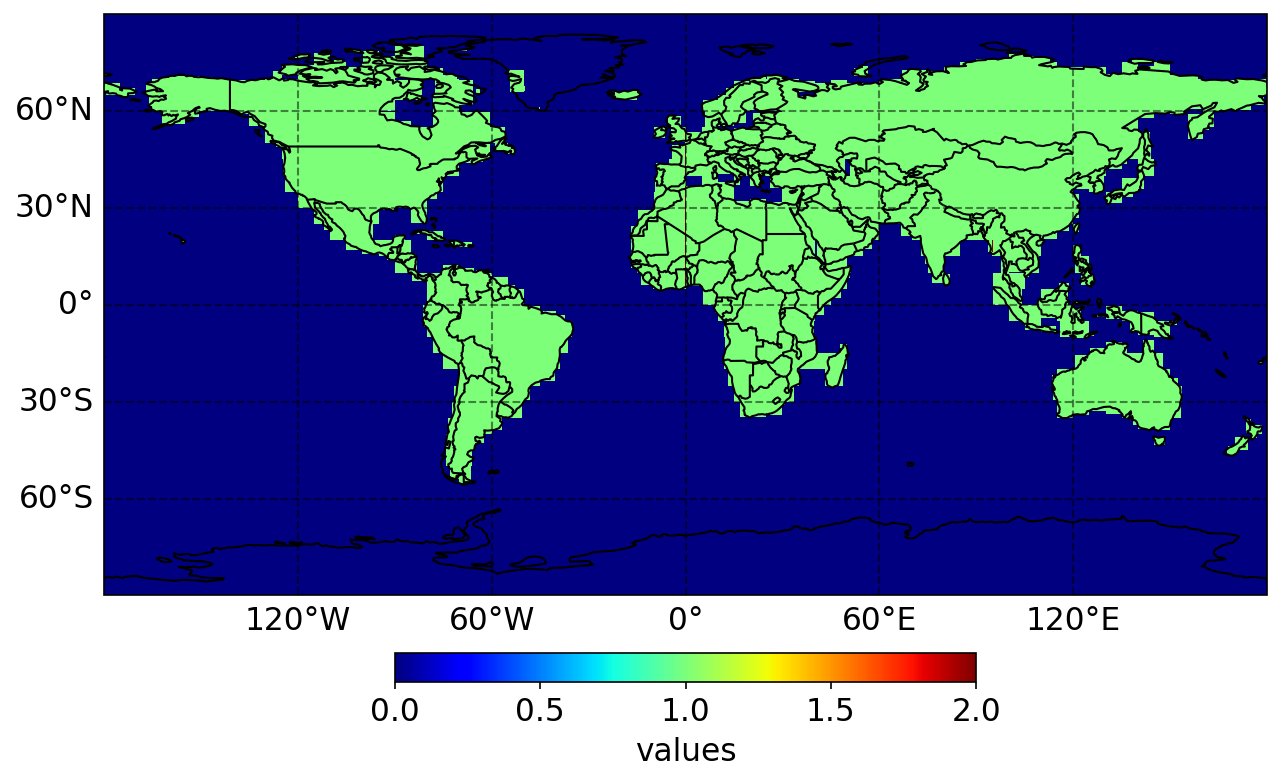

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [28]:
# Check previous nc files
orbit = 0

# for a single year
ASCAT_nc_FP = cpuserver_data_FP + '/ASCAT/TUW/nc_3d/2022'
target_nc_file_path = hData.get_file_list(ASCAT_nc_FP, 'nc', recursive=False, filter_strs=[am_pm[orbit]])

# for a entire year
#ASCAT_nc_FP = cpuserver_data_FP + '/ASCAT/TUW/nc_3d'
#target_nc_file_path = hData.get_file_list(ASCAT_nc_FP, 'nc', recursive=False, filter_strs=[am_pm[orbit]])

hData.get_nc_variable_names_units(target_nc_file_path[0]);

check_final_frame = hData.create_3d_np_array(target_lon.shape[0], target_lon.shape[1], 0, 0)
for i in tqdm(range(len(target_nc_file_path))): 
    
    t_check_final_frame = hData.create_3d_np_array(target_lon.shape[0], target_lon.shape[1], 0, 0)
    
    t_ASCAT_file_name = target_nc_file_path[i]
    t_lat = hData.get_variable_from_nc(t_ASCAT_file_name, 'latitude')
    t_lon = hData.get_variable_from_nc(t_ASCAT_file_name, 'longitude')
    t_R_ASCAT_SM_gldas    = hData.get_variable_from_nc(t_ASCAT_file_name, 'Resampled_ASCAT_SM_gldas')
    t_R_ASCAT_SM_gldas_QC = hData.get_variable_from_nc(t_ASCAT_file_name, 'Resampled_ASCAT_SM_gldas_QC')
    t_R_ASCAT_SM_hwsd     = hData.get_variable_from_nc(t_ASCAT_file_name, 'Resampled_ASCAT_SM_hwsd')
    t_R_ASCAT_SM_hwsd_QC  = hData.get_variable_from_nc(t_ASCAT_file_name, 'Resampled_ASCAT_SM_hwsd_QC')
    
    ul_y, ul_x = hData.find_closest_index(target_lon, target_lat, [t_lon[0,0], t_lat[0,0]])
    lr_y, lr_x = hData.find_closest_index(target_lon, target_lat, [t_lon[-1,-1], t_lat[-1,-1]])

    t_check_final_frame[ul_y:lr_y+1, ul_x:lr_x+1] = 1  
    check_final_frame += t_check_final_frame
    
hPlot.plot_map(target_lon, target_lat, check_final_frame, 0, np.max(check_final_frame), projection='PlateCarree')

In [80]:
# [Operational] Create the final ASCAT nc files
for orbit in am_pm:
    target_nc_file_path = hData.get_file_list(ASCAT_nc_FP, 'nc', recursive=False, filter_strs=[orbit])

    final_target_frame_gldas    = hData.create_3d_np_array(target_lon.shape[0], target_lon.shape[1], num_days+1)
    final_target_frame_gldas_QC = hData.create_3d_np_array(target_lon.shape[0], target_lon.shape[1], num_days+1)
    final_target_frame_hwsd     = hData.create_3d_np_array(target_lon.shape[0], target_lon.shape[1], num_days+1)
    final_target_frame_hwsd_QC  = hData.create_3d_np_array(target_lon.shape[0], target_lon.shape[1], num_days+1)
    
    for i in tqdm(range(len(target_nc_file_path))): 
    
        t_ASCAT_file_name = target_nc_file_path[i]
        t_lat = hData.get_variable_from_nc(t_ASCAT_file_name, 'latitude')
        t_lon = hData.get_variable_from_nc(t_ASCAT_file_name, 'longitude')
        t_R_ASCAT_SM_gldas    = hData.get_variable_from_nc(t_ASCAT_file_name, 'Resampled_ASCAT_SM_gldas')
        t_R_ASCAT_SM_gldas_QC = hData.get_variable_from_nc(t_ASCAT_file_name, 'Resampled_ASCAT_SM_gldas_QC')
        t_R_ASCAT_SM_hwsd     = hData.get_variable_from_nc(t_ASCAT_file_name, 'Resampled_ASCAT_SM_hwsd')
        t_R_ASCAT_SM_hwsd_QC  = hData.get_variable_from_nc(t_ASCAT_file_name, 'Resampled_ASCAT_SM_hwsd_QC')
        
        ul_y, ul_x = hData.find_closest_index(target_lon, target_lat, [t_lon[0,0], t_lat[0,0]])
        lr_y, lr_x = hData.find_closest_index(target_lon, target_lat, [t_lon[-1,-1], t_lat[-1,-1]])
    
        final_target_frame_gldas[ul_y:lr_y+1, ul_x:lr_x+1, :]    = t_R_ASCAT_SM_gldas
        final_target_frame_gldas_QC[ul_y:lr_y+1, ul_x:lr_x+1, :] = t_R_ASCAT_SM_gldas_QC
        final_target_frame_hwsd[ul_y:lr_y+1, ul_x:lr_x+1, :]     = t_R_ASCAT_SM_hwsd
        final_target_frame_hwsd_QC[ul_y:lr_y+1, ul_x:lr_x+1, :]  = t_R_ASCAT_SM_hwsd_QC
        
    nc_file_name = 'ASCAT_TUW_'+str(start_year)+'_'+str(end_year)+'_'+orbit+'_'+resampled_name+'.nc'
    nc_file_name = os.path.join(nc_save_dir, nc_file_name)
    hData.create_netcdf_file(
            nc_file    = nc_file_name,
            latitude   = target_lat,
            longitude  = target_lon,
            Resampled_ASCAT_SM_gldas    = final_target_frame_gldas,
            Resampled_ASCAT_SM_gldas_QC = final_target_frame_gldas_QC,
            Resampled_ASCAT_SM_hwsd     = final_target_frame_hwsd,
            Resampled_ASCAT_SM_hwsd_QC  = final_target_frame_hwsd_QC,
    )

100%|█████████████████████████████████████████| 851/851 [02:22<00:00,  5.98it/s]


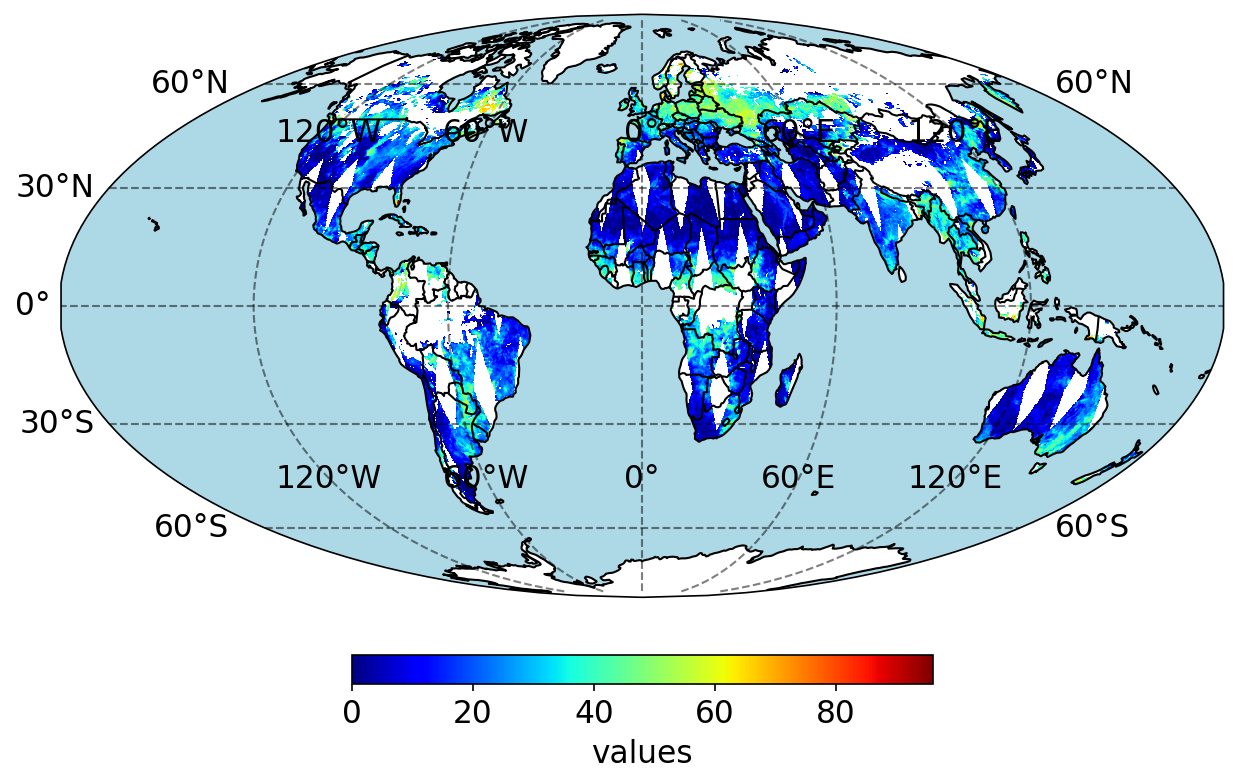

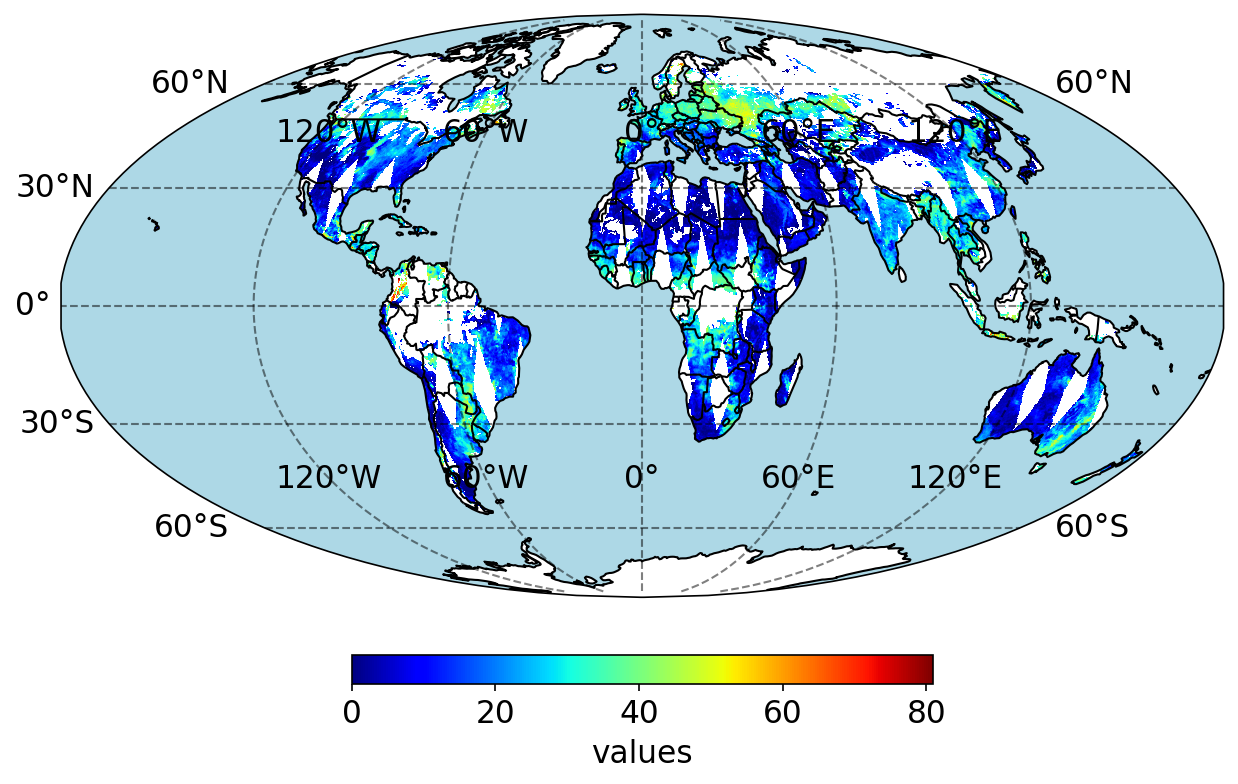

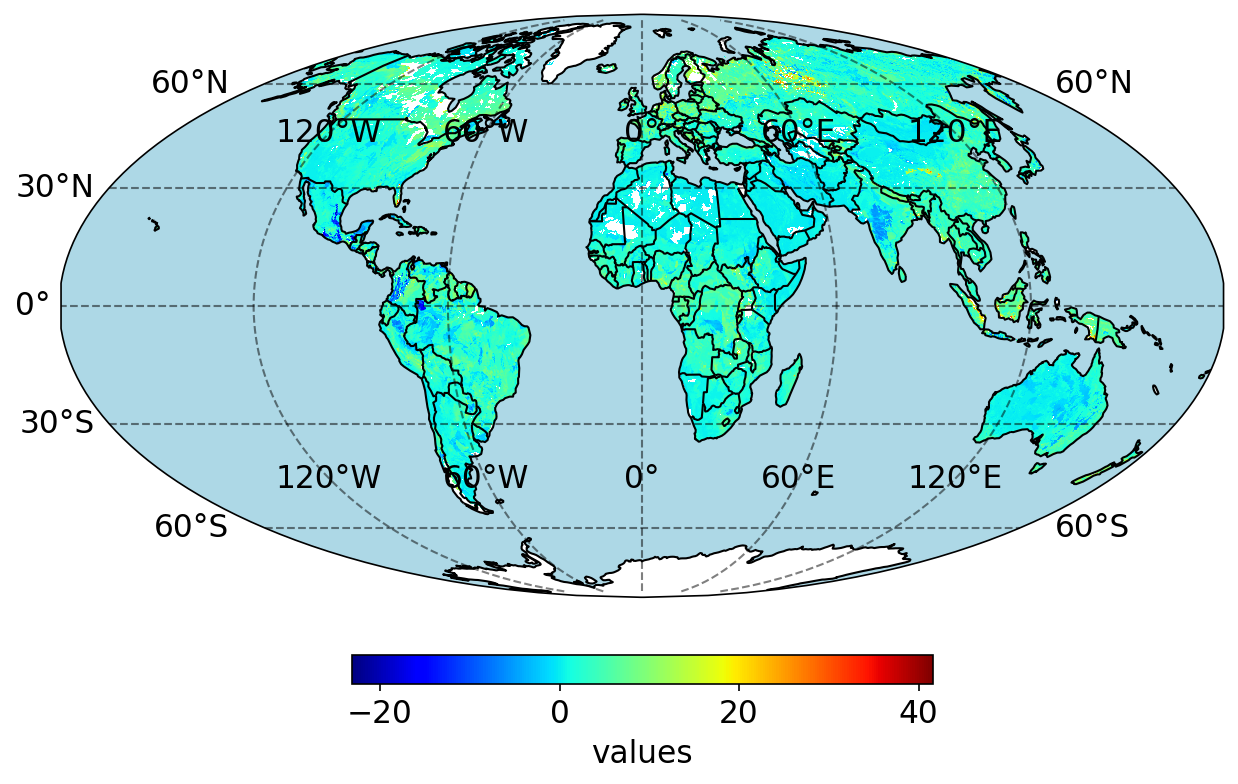

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [30]:
# Check the final files
target = final_target_frame_gldas_QC[:,:,300]
hPlot.plot_map(target_lon, target_lat, target, np.nanmin(target), np.nanmax(target))
target = final_target_frame_hwsd_QC[:,:,300]
hPlot.plot_map(target_lon, target_lat, target, np.nanmin(target), np.nanmax(target))
target = final_target_frame_gldas - final_target_frame_hwsd
target = np.nanmean(target, axis=2)
hPlot.plot_map(target_lon, target_lat, target, np.nanmin(target), np.nanmax(target))